# Implicit hate speech detection

In [ ]:
# !pip install evaluate
# !pip install seqeval
# !pip install ipywidgets
# !pip install transformers datasets seqeval evaluate
# !pip install pyfunctional
# !pip install torch torchvision
# !pip install spacy
# !pip install -U spacy
# !python -m spacy download en_core_web_sm
# !python -m spacy validate
# !pip install "numpy<2"
# !pip install "thinc<8.3.6"
# !pip install transformers
# !pip install --upgrade transformers
# !pip install 'accelerate>=0.26.0'
# !pip install nltk
!pip install pandas


In [ ]:
import sys
print(sys.executable)

In [2]:
!pip install "numpy<2"

  Using cached numpy-1.26.4-cp312-cp312-macosx_10_9_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-macosx_10_9_x86_64.whl (20.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5


In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tree import Tree
from nltk.stem.porter import PorterStemmer
import re
from collections import Counter
import string
import pandas as pd
# import spacy
# from spacy.tokens import Doc
# from spacy import displacy
# import benepar
from itertools import chain
import sklearn
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
import pickle
import networkx as nx
import os, logging
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from itertools import combinations
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt
import re
from datasets import load_dataset
from evaluate import load
import pandas as pd
from datasets import Dataset
import os


import csv

import pkg_resources
import subprocess
import sys
import os

import pandas as pd
from numpy import log, mean
from pandas import Series, DataFrame

from typing import List, Tuple, Union
import glob

from functional import seq
# from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from IPython.display import clear_output
from typing import Dict, List, Tuple, Union
from sklearn.model_selection import train_test_split

from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, set_seed
from transformers import DataCollatorWithPadding


In [2]:
model_checkpoint = "bert-base-uncased"
task = "hate_detection"
batch_size = 16

In [ ]:
import torch
x = torch.rand(5, 3)
print(x)

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
model = BertForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=3  
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Data analysis


Class (implicit_hate and not_hate labels) are in dataset "./implicit_hate_v1_stg1.tsv"

Implicit class (white grievance, irony, stereotypical) are in dataset "./implicit_hate_v1_stg2_posts.tsv"

Target groups (minority, immigrants) are in dataset "./implicit_hate_v1_stg3_posts.tsv"

In [7]:
binary_labels_data = "implicit-hate-corpus/implicit_hate_v1_stg1_posts.tsv"
implicit_class_data = "implicit-hate-corpus/implicit_hate_v1_stg2_posts.tsv"
target_group_data = "implicit-hate-corpus/implicit_hate_v1_stg3_posts.tsv"

In [9]:
df_stg1_posts = pd.read_csv(binary_labels_data, delimiter='\t')
print(df_stg1_posts)

                                                    post          class
0        " : jewish harvard professor noel ignatiev w...  implicit_hate
1       b.higher education is a part of european cult...       not_hate
2       has a problem with  " the whites " " and " " ...       not_hate
3       is yasir qadhi a hate preacher for calling ch...       not_hate
4       rt  " : how three million germans mass murder...       not_hate
...                                                  ...            ...
21475  Seeing prostitutes is morally wrong, but being...  implicit_hate
21476  I wonder how many females I raped today I spen...  implicit_hate
21477  Having a criminal record is more attractive to...  implicit_hate
21478  Another advantage of being a female: getting b...  implicit_hate
21479  If men are so privileged and women have it so ...  implicit_hate

[21480 rows x 2 columns]


In [11]:
df_stg2_posts = pd.read_csv(implicit_class_data, delimiter='\t')
print(df_stg2_posts)

                                                   post   implicit_class  \
0       " : jewish harvard professor noel ignatiev w...  white_grievance   
1      rt : tune in today's jmt for my interview w /...            irony   
2     : : hate posters ? you want hate buddy ? read ...  white_grievance   
3     : hunt for white women : black racist serial k...    stereotypical   
4     : looks like he was a fan of the islamic jew-h...    stereotypical   
...                                                 ...              ...   
6341  Seeing prostitutes is morally wrong, but being...            irony   
6342  I wonder how many females I raped today I spen...            irony   
6343  Having a criminal record is more attractive to...    stereotypical   
6344  Another advantage of being a female: getting b...      inferiority   
6345  If men are so privileged and women have it so ...            irony   

     extra_implicit_class  
0                     NaN  
1                     NaN  
2  

In [13]:
df_stg3_posts = pd.read_csv(target_group_data, delimiter='\t')
print(df_stg3_posts)

                                                    post            target  \
0       rt  " white privilege " " is when the gun jam...   minority groups   
1       rt  " white privilege " " is when the gun jam...      Black people   
2        if you are white in that state watch yourself !  non-white people   
3        if you are white in that state watch yourself !      white people   
4      so the 500 % increase in h1b visas ? yeah i'm ...        Immigrants   
...                                                  ...               ...   
12031   every india lover must boycott these pigs movies      Indian folks   
12032   every india lover must boycott these pigs movies     Indian people   
12033  ask more rss intellectuals to come on powerful...      Indian folks   
12034  ask more rss intellectuals to come on powerful...      Indian folks   
12035  cong stooges in msm who underplay the darkest ...      Indian folks   

                                implied_statement  
0      peop

### Count per class

In [15]:
df_stg1_posts = pd.read_csv(binary_labels_data, delimiter='\t')
df_stg1_posts['class'].value_counts()

class
not_hate         13291
implicit_hate     7100
explicit_hate     1089
Name: count, dtype: int64

In [17]:
df_stg2_posts = pd.read_csv(implicit_class_data, delimiter='\t')
df_stg2_posts['implicit_class'].value_counts()

implicit_class
white_grievance    1538
incitement         1269
stereotypical      1133
inferiority         863
irony               797
threatening         666
other                80
Name: count, dtype: int64

In [19]:
df_stg3_posts = pd.read_csv(target_group_data, delimiter='\t')
target_counts = df_stg3_posts['target'].value_counts()
print(target_counts)

target
Immigrants                     1338
Minorities                     1228
white people                   1204
Muslims                        1126
Jews                            847
                               ... 
Immigrants and Minorities         1
Mainstream christians             1
Conservative jews                 1
Wealthy jews and minorities       1
Perkins                           1
Name: count, Length: 1037, dtype: int64


In [21]:
target_size = df_stg3_posts.groupby('target').size()
print(target_size)

target
"they" (group is not specified)    1
3rd world countries                1
A group                            2
ACLU                               1
ANTIFA folks                       1
                                  ..
working white class                1
young black men                    1
young white men                    1
young, unemployed people           1
zoggies                            1
Length: 1037, dtype: int64


### Checking the labels in 3 datasets

In [23]:
df_stg1_posts['class'].unique()

array(['implicit_hate', 'not_hate', 'explicit_hate'], dtype=object)

In [25]:
df_stg2_posts['implicit_class'].unique()

array(['white_grievance', 'irony', 'stereotypical', 'incitement', 'other',
       'threatening', 'inferiority'], dtype=object)

In [27]:
df_stg3_posts['target'].unique()

array(['minority groups', 'Black people', 'non-white people', ...,
       'Young Immigrants', 'LGBT and anti-fascist groups', 'Perkins'],
      dtype=object)

In [29]:
unique_labels = df_stg3_posts['target'].unique()
num_unique_labels = len(unique_labels)

print(f"Number of unique labels: {num_unique_labels}")

Number of unique labels: 1038


In [31]:
top_10_labels = df_stg3_posts['target'].value_counts().head(10)

print(top_10_labels)


target
Immigrants          1338
Minorities          1228
white people        1204
Muslims             1126
Jews                 847
non-white people     458
Blacks               423
immigrants           284
White people         272
Black people         266
Name: count, dtype: int64


### Most frequent tokens per dataset

### Dataset 1 ('not hate,' 'explicit hate,' 'implicit hate')

In [33]:
import en_core_web_sm
nlp = en_core_web_sm.load()

# nlp = spacy.load("en_core_web_sm")

In [34]:
def log_LhArr(src_arr: Series, ref_arr: Series):
  """
  Vectorized log-likelihood test.
  
  Parameters:
  -----------
  - src_arr: sum of tokens across all documents in the source group. Shape (1, n)
  - ref_arr: sum of tokens across all documents in the reference group. Shape (1, n)
  
  Order in which parameters are passed does not affect the results.
  """
  src_count: int = src_arr.sum()
  ref_count: int = ref_arr.sum()
  
  agg = (src_arr + ref_arr) / (src_count + ref_count)
  e1 = src_count * agg
  e2 = ref_count * agg
  
  p1 = src_arr * log(src_arr / e1)
  p2 = ref_arr * log(ref_arr / e2)

  return 2 * (p1 + p2)
  
  
def topWordsByLogLikelihood(
  docWordMatrix: DataFrame, 
  labels: List[str], 
  topN: int) -> Tuple[Series, Series, Series]:
  """
  Prints top words sorted by log likelihood test. 
  Assumes matrix has 3 labels.
  """
  # Get unique labels in a predictable order
  unique_labels = sorted(list(set(labels)))
  
  if len(unique_labels) != 3:
    raise ValueError(f"Expected exactly 3 unique labels, but found {len(unique_labels)}: {unique_labels}")
    
  label1, label2, label3 = unique_labels
  
  aggDf = docWordMatrix.assign(label=labels).groupby('label').sum().T
  
  # Calculate log likelihood for each label vs. others
  aggDf = aggDf.assign(
    # Differences between labels
    l1_vs_l2 = aggDf[label1] - aggDf[label2],
    l1_vs_l3 = aggDf[label1] - aggDf[label3],
    l2_vs_l1 = aggDf[label2] - aggDf[label1],
    l2_vs_l3 = aggDf[label2] - aggDf[label3],
    l3_vs_l1 = aggDf[label3] - aggDf[label1],
    l3_vs_l2 = aggDf[label3] - aggDf[label2],
    
    # Log likelihood tests
    l1_likelihood = log_LhArr(aggDf[label1].replace(0, 0.01), 
                             (aggDf[label2] + aggDf[label3]).replace(0, 0.01)),
    l2_likelihood = log_LhArr(aggDf[label2].replace(0, 0.01), 
                             (aggDf[label1] + aggDf[label3]).replace(0, 0.01)),
    l3_likelihood = log_LhArr(aggDf[label3].replace(0, 0.01), 
                             (aggDf[label1] + aggDf[label2]).replace(0, 0.01))
  )
  
  # Boolean masks for each label (words more common in this label than others)
  label1_mask = (aggDf['l1_vs_l2'] > 0) & (aggDf['l1_vs_l3'] > 0)
  label2_mask = (aggDf['l2_vs_l1'] > 0) & (aggDf['l2_vs_l3'] > 0)
  label3_mask = (aggDf['l3_vs_l1'] > 0) & (aggDf['l3_vs_l2'] > 0)
  
  # Get top words for each label
  l1 = aggDf[label1_mask].sort_values(by='l1_likelihood', ascending=False)[:topN]['l1_likelihood']
  l2 = aggDf[label2_mask].sort_values(by='l2_likelihood', ascending=False)[:topN]['l2_likelihood']
  l3 = aggDf[label3_mask].sort_values(by='l3_likelihood', ascending=False)[:topN]['l3_likelihood']
  
  print(f"\nTop {label1} tokens by likelihood:\n")
  print(l1)
  print(f"\nTop {label2} tokens by likelihood:\n")
  print(l2)
  print(f"\nTop {label3} tokens by likelihood:\n")
  print(l3)
  
  return (l1, l2, l3)

### The code is from https://github.com/PyAntony/hate-speech/blob/master/notebooks/EDA.ipynb

In [35]:
def hateTokenizer(text: str, spacyModel=nlp):
  """
  Simple tokenizer to:
    - extract alphabetical tokens
    - remove stopwords
    - lemmatize and lowercase tokens 
  """
  doc = spacyModel(text)
  
  return seq(token for token in doc)\
    .filter(lambda t: t.is_alpha)\
    .filter_not(lambda t: t.is_stop)\
    .map(lambda t: t.lemma_.lower())\
    .to_list()

### The code is from https://github.com/PyAntony/hate-speech/blob/master/notebooks/EDA.ipynb

In [36]:
def rawCorpusToDf(
  corpus: Union[List[str], Series], 
  tokenizer=hateTokenizer, 
  idf=False) -> DataFrame:
  """Tokenize corpus and build doc-term matrix."""
  vectorizer = (
    TfidfVectorizer(tokenizer=tokenizer, lowercase=False) 
    if idf else
    CountVectorizer(tokenizer=tokenizer, lowercase=False)
  )

  X = vectorizer.fit_transform(corpus)

  return pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

### The code is from https://github.com/PyAntony/hate-speech/blob/master/notebooks/EDA.ipynb

In [37]:
count_df = rawCorpusToDf(df_stg1_posts['post'])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [38]:
l1, l2, l3 = topWordsByLogLikelihood(count_df, df_stg1_posts['class'].tolist(), 10)


Top explicit_hate tokens by likelihood:

faggot     244.893706
nigger     213.989283
trash      161.939214
filthy      59.249884
queer       41.252064
kike        40.815618
retard      34.873439
sand        32.145283
cracker     22.214993
fag         21.208235
Name: l1_likelihood, dtype: float64

Top implicit_hate tokens by likelihood:

illegal          378.024000
black            186.282834
deport           152.497307
whitegenocide     93.419525
country           85.119752
jews              83.552970
muslim            69.908199
non               67.999386
genocide          63.472067
alien             52.969083
Name: l2_likelihood, dtype: float64

Top not_hate tokens by likelihood:

cruz         124.245225
white        118.940121
trump        106.549130
kill         105.988389
alt           97.780039
bjp           74.283228
religious     71.339128
sure          70.761668
modi          70.085837
race          69.122019
Name: l3_likelihood, dtype: float64


### Dataset 2 (implicit classes)

In [39]:
def log_LhArr(src_arr: Series, ref_arr: Series):
    src_count: int = src_arr.sum()
    ref_count: int = ref_arr.sum()
    
    agg = (src_arr + ref_arr) / (src_count + ref_count)
    e1 = src_count * agg
    e2 = ref_count * agg

    # Avoid division by zero and log(0)
    src_arr = src_arr.replace(0, 0.01)
    ref_arr = ref_arr.replace(0, 0.01)
    e1 = e1.replace(0, 0.01)
    e2 = e2.replace(0, 0.01)

    p1 = src_arr * log(src_arr / e1)
    p2 = ref_arr * log(ref_arr / e2)

    return 2 * (p1 + p2)

def topWordsByLogLikelihood(
    docWordMatrix: DataFrame,
    labels: List[str],
    topN: int
) -> dict:
    """
    Prints top words sorted by log-likelihood test for each label.

    Parameters:
    -----------
    - docWordMatrix: word counts per document
    - labels: list of labels for each document
    - topN: how many top words to return per label

    Returns:
    --------
    A dictionary where keys are labels and values are Series of topN words.
    """
    unique_labels = sorted(set(labels))

    if len(unique_labels) < 2:
        raise ValueError("Need at least 2 unique labels.")

    aggDf = docWordMatrix.assign(label=labels).groupby('label').sum().T
    results = {}

    for label in unique_labels:
        # All other labels combined
        others = [l for l in unique_labels if l != label]
        ref_sum = aggDf[others].sum(axis=1)
        src = aggDf[label]

        # Compute log-likelihood
        likelihood = log_LhArr(src, ref_sum)
        mask = (src > ref_sum)  # Only words more frequent in src than reference
        top_words = likelihood[mask].sort_values(ascending=False).head(topN)

        print(f"\nTop {label} tokens by likelihood:\n")
        print(top_words)

        results[label] = top_words

    return results

### The code is from https://github.com/PyAntony/hate-speech/blob/master/notebooks/EDA.ipynb

In [44]:
count_df = rawCorpusToDf(df_stg2_posts['post'])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [45]:
l1, l2, l3, l4, l5, l6, l7 = topWordsByLogLikelihood(count_df, df_stg2_posts['implicit_class'].tolist(), 10)


Top incitement tokens by likelihood:

aryan         75.621139
hitler        65.402003
resister      59.517647
adolf         55.844740
alt           51.628837
shirt         49.047617
kkk           45.800683
power         39.174052
pride         37.982568
whitepride    34.710165
dtype: float64

Top inferiority tokens by likelihood:

iq              80.212580
animal          74.061041
low             59.319248
civilization    47.422275
rat             44.924388
savage          41.875683
parasite        41.461672
monkey          41.038998
degenerate      40.051961
pig             38.344356
dtype: float64

Top irony tokens by likelihood:

difference    82.845065
number        49.986938
repeat        49.582040
ethiopian     29.884313
jerome        29.884313
car           27.128101
joke          25.376663
cotton        24.233858
parrot        21.315945
tree          20.976808
dtype: float64

Top other tokens by likelihood:

cuck             116.343805
cuckservative     88.159646
asexual     

## Splitting the dataset 1 ('not hate,' 'explicit hate,' 'implicit hate') into train, dev, test

In [16]:
df = pd.read_csv(binary_labels_data, sep='\t', header=0)  

train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
dev_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_df.to_csv('train_data.tsv', sep='\t', index=False)
dev_df.to_csv('dev_data.tsv', sep='\t', index=False)
test_df.to_csv('test_data.tsv', sep='\t', index=False)

print(f"Total dataset size: {len(df)} sentences")
print(f"Train set: {len(train_df)} sentences ({len(train_df)/len(df)*100:.1f}%)")
print(f"Dev set: {len(dev_df)} sentences ({len(dev_df)/len(df)*100:.1f}%)")
print(f"Test set: {len(test_df)} sentences ({len(test_df)/len(df)*100:.1f}%)")

Total dataset size: 21480 sentences
Train set: 12888 sentences (60.0%)
Dev set: 4296 sentences (20.0%)
Test set: 4296 sentences (20.0%)


In [9]:
trainset = "train_data.tsv"
devset = "dev_data.tsv"
testset = "test_data.tsv"

In [64]:
trainset_read = pd.read_csv(trainset, delimiter='\t')
print(trainset_read[:10])

                                                post          class
0  they are not dreamers, if they are illegal the...  implicit_hate
1   i get it . you feel bad for being white . you...       not_hate
2  saudi arabia is a disgusting, inhuman regime. ...  explicit_hate
3  2 hollywood jews want us to feel bad for not i...  explicit_hate
4  technically  the kkk commits no crimes . they ...       not_hate
5  poland uncovers thousands more staff at auschw...       not_hate
6                     its about erasing white people  implicit_hate
7  we who are pro-white want to preserve the whit...  implicit_hate
8  the yankees are so disenchanted with their wom...  implicit_hate
9                rape of europe  5sept2015 #altright       not_hate


In [66]:
devset_read = pd.read_csv(devset, delimiter='\t')
print(devset_read[:10])

                                                post          class
0  white community was a safe white community til...  explicit_hate
1  a fetus is a baby and needs to be treated w / ...       not_hate
2  that's not what he was saying . women voting o...  implicit_hate
3  thats why dhs should put chutes on illegals, l...  implicit_hate
4  : abortion has a market problem : #hb2 #protec...       not_hate
5    " police continue to stand down  people will...       not_hate
6  you have a good work ethic  and i'm sure a few...       not_hate
7                                        hello white       not_hate
8   rt but the  " third great awakening " " is ab...       not_hate
9  not wanting your people and culture erased is ...       not_hate


In [68]:
testset_read = pd.read_csv(testset, delimiter='\t')
print(testset_read[:10])

                                                post          class
0  more i learn  more i realize how similar jews ...  explicit_hate
1            they move into the third mixed nation .  implicit_hate
2  npr says southern baptists are raising the whi...       not_hate
3  wal mart queen hillary pontificates that modi ...       not_hate
4  trumps so mentally unstable calling himself wh...       not_hate
5  need a massive deportation program ... around ...  implicit_hate
6  democrats in white hoods have hung white repub...  implicit_hate
7  trump needs his hud examined : not a fan of fa...  explicit_hate
8  very unlikely for most unless its a massive pu...       not_hate
9  not generally . in some states  1/2 of black p...  implicit_hate


## Loading the dataset

In [11]:
with open(trainset, "r") as file:
    for i, line in enumerate(file):
        if i < 5:  # Print the first 5 lines
            print(line.strip())


post	class
"they are not dreamers, if they are illegal they aren't immigrant they are """"intruder invaders""""."	implicit_hate
" i get it . you feel bad for being white . you assume  "" white privilege "" "" and "" "" the patriarchy "" "" must be torn down . you want to help . not me . """	not_hate
saudi arabia is a disgusting, inhuman regime. truly evil. lower than vermin. still, business is business. kerching!	explicit_hate
2 hollywood jews want us to feel bad for not importing jihadists whose doctrine has more jew hate than mein kampf	explicit_hate


In [13]:
data = []
with open(trainset, "r") as file:
    for line in file:
        row = line.strip().split('\t')
        if len(row) >= 2:  # Ensure there are at least 2 columns
            data.append([row[0], row[1]])  # Select only the first two columns

df_train = pd.DataFrame(data, columns=['post', 'class'])

In [74]:
print("Train DataFrame columns:", df_train.columns.tolist())

Train DataFrame columns: ['post', 'class']


In [15]:
data = []
with open(devset, "r") as file:
    for line in file:
        row = line.strip().split('\t')
        if len(row) >= 2:   
            data.append([row[0], row[1]])   

df_dev = pd.DataFrame(data, columns=['post', 'class'])

In [80]:
print("Train DataFrame columns:", df_dev.columns.tolist())

Train DataFrame columns: ['post', 'class']


In [17]:
data = []
with open(testset, "r") as file:
    for line in file:
        row = line.strip().split('\t')
        if len(row) >= 2:   
            data.append([row[0], row[1]])  # Select only the first two columns

df_test = pd.DataFrame(data, columns=['post', 'class'])


In [84]:
print("Train DataFrame columns:", df_test.columns.tolist())

Train DataFrame columns: ['post', 'class']


In [86]:
df_train['class'].value_counts()

class
not_hate         7919
implicit_hate    4296
explicit_hate     672
class               1
                    1
Name: count, dtype: int64

In [90]:
df_dev['class'].value_counts()

class
not_hate         2677
implicit_hate    1397
explicit_hate     222
class               1
Name: count, dtype: int64

In [92]:
df_test['class'].value_counts()

class
not_hate         2695
implicit_hate    1406
explicit_hate     195
class               1
Name: count, dtype: int64

## Data Preprocessing

In our dataset, the labels are organized like this:

not_hate
implicit_hate
explicit_hate


In [19]:
model.resize_token_embeddings(len(tokenizer))

Embedding(30522, 768, padding_idx=0)

In [21]:
dataset_train = load_dataset('csv', data_files={'train': 'train_data.tsv'}, delimiter='\t')
dataset_dev = load_dataset('csv', data_files={'dev': 'dev_data.tsv'}, delimiter='\t')
dataset_test = load_dataset('csv', data_files={'test': 'test_data.tsv'}, delimiter='\t')

tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["post"], truncation=True, padding=True, max_length=512)

    # Mapping the 'class' labels to numerical labels (0 = not_hate, 1 = implicit_hate, 2 = explicit_hate)
    label_mapping = {"not_hate": 0, "implicit_hate": 1, "explicit_hate": 2}
    labels = [label_mapping[label] for label in examples["class"]]

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [23]:
tokenized_datasets_train = dataset_train['train'].map(tokenize_and_align_labels, batched=True)

print(tokenized_datasets_train[10])

{'post': 'be brave and admit you a / zionist racist full of hate islam historicallywhat about your money collect', 'class': 'explicit_hate', 'input_ids': [101, 2022, 9191, 1998, 6449, 2017, 1037, 1013, 21379, 16939, 2440, 1997, 5223, 7025, 7145, 2860, 12707, 2055, 2115, 2769, 8145, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 2}


In [25]:
tokenized_datasets_dev = dataset_dev['dev'].map(tokenize_and_align_labels, batched=True)

print(tokenized_datasets_dev[10])

{'post': 'interfered in their elect and inserted yeltsin  that the real numbers showed that communist party won and victory shld had gone 2 zyuganov', 'class': 'not_hate', 'input_ids': [101, 28976, 1999, 2037, 11322, 1998, 12889, 6300, 21593, 2378, 2008, 1996, 2613, 3616, 3662, 2008, 4750, 2283, 2180, 1998, 3377, 14021, 6392, 2018, 2908, 1016, 1062, 10513, 29451, 2615, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [27]:
tokenized_datasets_test = dataset_test['test'].map(tokenize_and_align_labels, batched=True)

print(tokenized_datasets_test[10])

{'post': 'jew is someone who punches you and cries out in pain . dirty vermin .', 'class': 'explicit_hate', 'input_ids': [101, 16522, 2003, 2619, 2040, 17957, 2017, 1998, 12842, 2041, 1999, 3255, 1012, 6530, 2310, 27512, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 2}


## Fine tuning the model

In [29]:
from transformers import BertModel
label_list = ["not_hate", "implicit_hate", "explicit_hate"]
num_labels = len(label_list)

model = BertModel.from_pretrained(model_checkpoint)

In [31]:
label_list

['not_hate', 'implicit_hate', 'explicit_hate']

In [33]:
# metric = load("seqeval")

from evaluate import load
accuracy_metric = load("accuracy")
f1_metric = load("f1")

In [34]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions.tolist(), references=labels.tolist())["accuracy"],
        "f1": f1_metric.compute(predictions=predictions.tolist(), references=labels.tolist(), average="weighted")["f1"],
    }

In [53]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [44]:
SEED = 15
set_seed(SEED)

model_name = model_checkpoint.split("/")[-1]
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=3
)

args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-{task}",
    eval_strategy=
"epoch",   
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    seed=SEED,
    report_to=None,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_dev,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/vd/xkcxq0p96sxd5bgjgdng13s00000gn/T/ipykernel_5290/359801845.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [46]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.697900,0.562575,0.751629,0.732729
2,0.421600,0.597819,0.757449,0.753191


TrainOutput(global_step=1612, training_loss=0.5410966068580192, metrics={'train_runtime': 28148.7612, 'train_samples_per_second': 0.916, 'train_steps_per_second': 0.057, 'total_flos': 2300737725262368.0, 'train_loss': 0.5410966068580192, 'epoch': 2.0})

In [47]:
trainer.evaluate()

{'eval_loss': 0.5978190898895264,
 'eval_accuracy': 0.7574487895716946,
 'eval_f1': 0.7531911927293135,
 'eval_runtime': 693.5933,
 'eval_samples_per_second': 6.194,
 'eval_steps_per_second': 0.388,
 'epoch': 2.0}

In [48]:
def evaluate_predictions(predictions, gold_labels, label_list):
    """
    Evaluate predictions against gold labels and print metrics.
    """
    predictions_flat = [label_list.index(label) for label in predictions]
    gold_labels_flat = [label_list.index(label) for label in gold_labels]

    accuracy = accuracy_score(gold_labels_flat, predictions_flat)
    report = classification_report(gold_labels_flat, predictions_flat, target_names=label_list, digits=4)

    cm = confusion_matrix(gold_labels_flat, predictions_flat, labels=list(range(len(label_list))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
   
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    disp.plot(cmap=plt.cm.Purples, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

In [49]:
predictions, labels, _ = trainer.predict(tokenized_datasets_dev)
predicted_indices = np.argmax(predictions, axis=1)

In [50]:
label_list = ["not_hate", "implicit_hate", "explicit_hate"]

# Convert class indices to string labels
predicted_labels = [label_list[i] for i in predicted_indices]
gold_labels = [label_list[i] for i in labels]

Accuracy: 0.7574487895716946
Classification Report:
                precision    recall  f1-score   support

     not_hate     0.8289    0.8416    0.8352      2677
implicit_hate     0.6438    0.6714    0.6573      1397
explicit_hate     0.5207    0.2838    0.3673       222

     accuracy                         0.7574      4296
    macro avg     0.6645    0.5989    0.6200      4296
 weighted avg     0.7528    0.7574    0.7532      4296



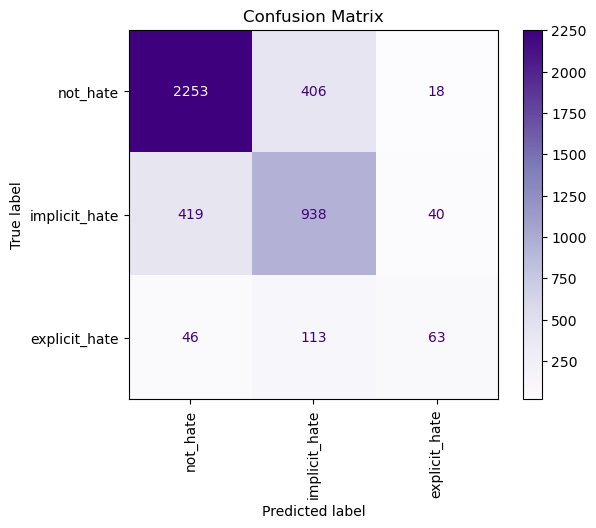

In [51]:
evaluate_predictions(predicted_labels, gold_labels, label_list)

In [52]:
print(tokenized_datasets_dev[0].keys())

posts = [example['post'] for example in tokenized_datasets_dev]  # adjust field name as needed

df = pd.DataFrame({
    "post": posts,
    "predicted_label": predicted_labels,
    "gold_label": gold_labels,
})
df.to_csv("predictions_vs_gold_train_dev.csv", index=False)

dict_keys(['post', 'class', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [53]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions.tolist(), references=labels.tolist())["accuracy"],
        "f1": f1_metric.compute(predictions=predictions.tolist(), references=labels.tolist(), average="weighted")["f1"],
    }

In [54]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

SEED = 15
set_seed(SEED)


model_name = model_checkpoint.split("/")[-1]

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=3
)

args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-{task}",
    eval_strategy="epoch",   
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    seed=SEED,
    report_to=None,
)

trainer1 = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/vd/xkcxq0p96sxd5bgjgdng13s00000gn/T/ipykernel_5290/2463675479.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer1 = Trainer(


In [55]:
trainer1.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.697900,0.561915,0.755587,0.739235
2,0.421600,0.583814,0.768622,0.765685


TrainOutput(global_step=1612, training_loss=0.5410966068580192, metrics={'train_runtime': 29632.8664, 'train_samples_per_second': 0.87, 'train_steps_per_second': 0.054, 'total_flos': 2300737725262368.0, 'train_loss': 0.5410966068580192, 'epoch': 2.0})

In [56]:
trainer1.evaluate()

{'eval_loss': 0.5838140845298767,
 'eval_accuracy': 0.7686219739292365,
 'eval_f1': 0.7656849707378769,
 'eval_runtime': 818.8118,
 'eval_samples_per_second': 5.247,
 'eval_steps_per_second': 0.329,
 'epoch': 2.0}

In [57]:
predictions, labels, _ = trainer1.predict(tokenized_datasets_test)
predicted_indices = np.argmax(predictions, axis=1)


In [58]:
label_list = ["not_hate", "implicit_hate", "explicit_hate"]

predicted_labels = [label_list[i] for i in predicted_indices]
gold_labels = [label_list[i] for i in labels]

Accuracy: 0.7686219739292365
Classification Report:
                precision    recall  f1-score   support

     not_hate     0.8362    0.8505    0.8433      2695
implicit_hate     0.6620    0.6714    0.6667      1406
explicit_hate     0.5116    0.3385    0.4074       195

     accuracy                         0.7686      4296
    macro avg     0.6699    0.6201    0.6391      4296
 weighted avg     0.7644    0.7686    0.7657      4296



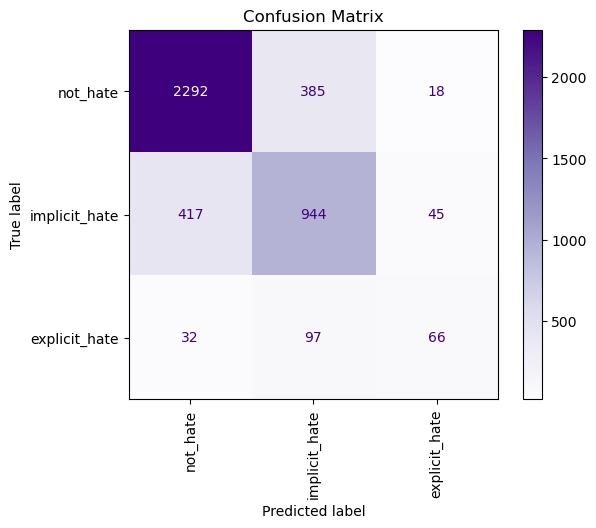

In [59]:
evaluate_predictions(predicted_labels, gold_labels, label_list)

In [60]:
print(tokenized_datasets_test[0].keys())

posts = [example['post'] for example in tokenized_datasets_test]  # adjust field name as needed

df = pd.DataFrame({
    "post": posts,
    "predicted_label": predicted_labels,
    "gold_label": gold_labels,
})
df.to_csv("predictions_vs_gold_train_test.csv", index=False)

dict_keys(['post', 'class', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'])
